In [26]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../")
from iotools.readOxford import ReadOxford
from iotools.readrpkm import ReadRPKM
from utils import mfunc
from utils import gtutils
from inference.linreg_association import LinRegAssociation
import numpy as np
from utils.containers import GeneInfo
from sklearn.preprocessing import scale

chrom = 12
oxf_file = "/usr/users/fsimone/datasets/gtex/GTEx_450Indiv_genot_imput_info04_maf01_HWEp1E6_dbSNP135IDs_donorIDs_dosage_chr{:d}.gz".format(chrom)
fam_file = "/usr/users/fsimone/datasets/gtex/donor_ids.fam"
dataset = "gtex"
nlocilimit = 10000

oxf = ReadOxford(oxf_file, fam_file, chrom, dataset, nlocilimit)
genotype = oxf.dosage
samplenames = oxf.samplenames
snps = oxf.snps_info

# Filter genotype and Quality control
snpinfo, gt = gtutils.remove_low_maf(snps, genotype, 0.1)
gt_norm = gtutils.normalize(snpinfo, gt)

# sample genotype randomly
nsnps = 200
sel_snps_ix = np.random.choice(gt_norm.shape[0], nsnps, replace = False)

gtnorm = gt_norm[sel_snps_ix,:]
X_info = [snpinfo[i] for i in sel_snps_ix]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2018-07-16 13:59:44,931 | iotools.readOxford | INFO | Reading genotype
2018-07-16 13:59:44,931 | iotools.readOxford | INFO | Reading genotype
2018-07-16 13:59:46,207 | iotools.readOxford | INFO | Read 10001 snps from 450 samples.
2018-07-16 13:59:46,207 | iotools.readOxford | INFO | Read 10001 snps from 450 samples.
2018-07-16 13:59:46,209 | iotools.readOxford | INFO | Finished reading genotype
2018-07-16 13:59:46,209 | iotools.readOxford | INFO | Finished reading genotype


In [2]:
# Simulate Genotype in place
from utils import model

nsample          = 450
nsnps            = 100

snpinfo, gtnorm = model.simulate_dosage(nsample, nsnps)


Sigma: 0.115606
Gamma:  [-2.19722458]
Causal SNPs: 23/200
Enrichment: [0.]
Tau: 1.2909944487358056
h2: 0.40347466457102793
geno_eff var: 0.40347466457102804
gx var: 1.0000000000000002
sigma check: 0.1318760946791574


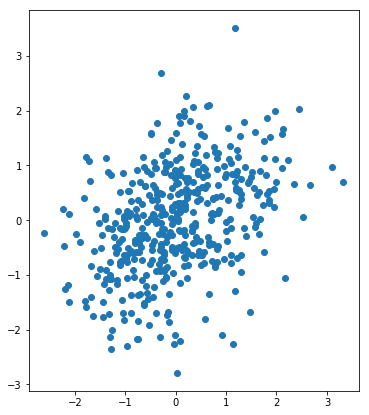

In [34]:
from utils import model
import matplotlib.pyplot as plt

nfeat_used       = 0 
nfeat_causal     = 0
base_pi          = 0.1
sigma_bg         = 0.00001
sigma            = 0.1

# gx, gx2, \
# gammas, ncausal, \
# enrichment, feat_enriched, \
# causal_feature, causal_ix = model.simulate_gx_with_params(gtnorm, nsnps, base_pi = base_pi, \
#                                                     nfeat=nfeat_used, nfeat_causal=nfeat_causal, \
#                                                     sigma = sigma, sigma_bg = sigma_bg, debug = True)


gx, gx2, \
gammas, ncausal, \
enrichment, feat_enriched, \
causal_feature, causal_ix, sigma, tau = model.simulate_gx_fixed_h2(gtnorm, nsnps, base_pi = base_pi, \
                            nfeat=nfeat_used, nfeat_causal=nfeat_causal, \
                            sigma_herited_sq = 0.4, debug = True)


# target = scale(gx, with_mean=True, with_std=True)
# print("Y scaled var:", np.std(target)**2)

fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(121)
ax.scatter(gx, gx2)
plt.show()

In [35]:
def reset_params(gammas, nfeat, mu, sigma, sigma_bg, tau):
    init_params = np.zeros(nfeat + 4)
    init_params[0] = gammas[0]
    if nfeat > 1:
        for i in range(1, nfeat):
            init_params[i] = gammas[i]
    init_params[nfeat + 0] = mu
    init_params[nfeat + 1] = sigma
    init_params[nfeat + 2] = sigma_bg
    init_params[nfeat + 3] = tau
    return init_params

def scramble_params(nfeat):
    init_params = np.zeros(nfeat + 4)
    init_params[0] = -1
    if nfeat > 1:
        for i in range(1, nfeat):
            init_params[i] = 0
    init_params[nfeat + 0] = 0.0
    init_params[nfeat + 1] = 0.1
    init_params[nfeat + 2] = 0.01
    init_params[nfeat + 3] = 1 / 0.01 / 0.05
    return init_params

target = gx
# target = scale(expression, with_mean=True, with_std=True)
predictor = gtnorm

znew = False

####################
#### Set initial params 
# g0       = -2
mu       = 0.0
# sigma    = 0.15
# sigma_bg = 0.01
# tau      = 0.05
nvar     = predictor.shape[0]

###### Acomodate features appropriately
if nfeat_used > 0:
    feature0 = np.ones((nsnps, 1))
    features = np.concatenate((feature0, causal_feature), axis=1)
else:
    features = np.ones((nsnps, 1))


dist_feature = np.ones(nsnps)
cmax = 1
nfeat = features.shape[1]
print("Loaded {:d} features".format(nfeat))

init_params = reset_params(gammas, nfeat, mu, sigma, sigma_bg, tau)
init_params

Loaded 1 features


array([-2.19722458e+00,  0.00000000e+00,  1.15606251e-01,  1.00000000e-05,
        1.29099445e+00])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[-1.e+00  0.e+00  1.e-01  1.e-02  2.e+03]
1.8496468091994143e-281 0.98
zstates.py: Working with 2 leading zstates.
6.051004362228204e-144 0.98
zstates.py: Working with 2 leading zstates.
2.7052929428946276e-133 0.98
zstates.py: Working with 2 leading zstates.
9.635189307661367e-106 0.98
zstates.py: Working with 2 leading zstates.
2.2746703497998848e-82 0.98
zstates.py: Working with 2 leading zstates.
1.582222271477658e-57 0.98
zstates.py: Working with 2 leading zstates.
2.7026587556758605e-38 0.98
zstates.py: Working with 2 leading zstates.
2.1921802169797947e-24 0.98
zstates.py: Working with 2 leading zstates.
9.490561676942343e-16 0.98
zstates.py: Working with 2 leading zstates.
5.094184626048133e-11 0.98
zstates.py: Working with 2 leading zstates.
8.126352953249333e-09 0.98
zstates.py: Working with 2 leading zstates.
9.134802521089698e-08 0.98
zstates.py: Working with 2 leading zstates.
1.5326968

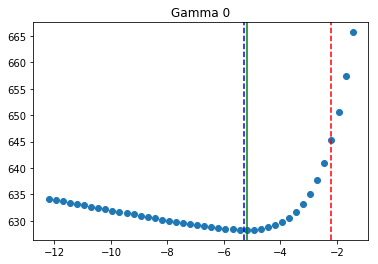

In [36]:
%load_ext autoreload
%autoreload 2

from iotools.io_model import WriteModel
from inference.empirical_bayes import EmpiricalBayes
from inference import logmarglik
from utils import hyperparameters
from utils.containers import ZstateInfo
from inference import zstates as zs

init_params = scramble_params(nfeat)
print(init_params)

emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, cmax, init_params, method="new")
emp_bayes.fit()  
res = emp_bayes.params

for i in range(nfeat):
    init_params = reset_params(gammas, nfeat, mu, sigma, sigma_bg, tau)
    gstart = gammas[i]-10
    gend   = gammas[i]+1
    step   = 0.25  
    
    G = np.arange(gstart, gend, step)
    LML = list()
    print("Testing gamma {:d}".format(i))
    for _g in G:
        print(".", end="")
        init_params[i] = _g
#         emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, cmax, init_params, method="basic")
        scaled_params = hyperparameters.scale(init_params)
        if znew:
            zstates = zs.create(scaled_params, predictor, target, features, dist_feature, cmax, nsnps, 0.98)
        else:
            zstates = [[]] + [[i] for i in range(nsnps)]
        lml = logmarglik.func(scaled_params, predictor, target, features, dist_feature, zstates)
        LML.append(lml)
    
    
    print(".")
    LML = np.array(LML)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(G, LML)
    ax.set_title("Gamma {:d}".format(i))
    actual_min = gstart + np.where(np.isin(LML, np.min(LML)))[0][0] * step
    print("Optimized grid min: ", actual_min)
    print("Optimized grad min: ", res[i])
    print("Simulated val: ", gammas[i])
    ax.axvline(gammas[i], color="red", linestyle="dashed")
    ax.axvline(res[i], color="blue", linestyle="dashed")
    ax.axvline(actual_min, color="green")
    # plt.xlim(-5, -3)
    plt.show()
    


Testing sigma
................................
Optimized min:  0.281
Optimized grad min:  0.2883077293766184
Simulated val:  0.11560625136024906


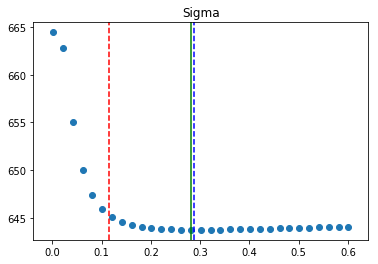

Testing sigma bg
..........................
Optimized min:  0.041
Optimized grad min:  0.03575267109438848
Simulated val:  1e-05


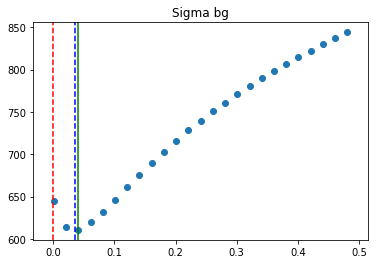

In [38]:
sstart = 0.001
send   = sigma+0.5
step   = 0.02

init_params = reset_params(gammas, nfeat, mu, sigma, sigma_bg, tau)
S = np.arange(sstart, send, step)
LML = list()
print("Testing sigma")
for _s in S:
    
    print(".", end="")
    init_params[nfeat + 1] = _s
#         emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, cmax, init_params, method="basic")
    scaled_params = hyperparameters.scale(init_params)
    if znew:
        zstates = zs.create(scaled_params, predictor, target, features, dist_feature, cmax, nsnps, 0.98)
    else:
        zstates = [[]] + [[i] for i in range(nsnps)]
    lml = logmarglik.func(scaled_params, predictor, target, features, dist_feature, zstates)
    LML.append(lml)
print(".")
LML = np.array(LML)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(S, LML)
ax.set_title("Sigma")
actual_min = sstart + np.where(np.isin(LML, np.min(LML)))[0][0] * step
print("Optimized min: ", actual_min)
print("Optimized grad min: ", res[nfeat+1])
print("Simulated val: ", sigma)
ax.axvline(res[nfeat+1], color="blue", linestyle="dashed")
ax.axvline(sigma, color="red", linestyle="dashed")
ax.axvline(actual_min, color="green")
# plt.xlim(-5, -3)
plt.show()

sstart = 0.001
send   = sigma_bg+0.5
step   = 0.02

init_params = reset_params(gammas, nfeat, mu, sigma, sigma_bg, tau)
S = np.arange(sstart, send, step)
LML = list()
print("Testing sigma bg")
for _s in S:
    
    print(".", end="")
    init_params[nfeat + 2] = _s
#         emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, cmax, init_params, method="basic")
    scaled_params = hyperparameters.scale(init_params)
    if znew:
        zstates = zs.create(scaled_params, predictor, target, features, dist_feature, cmax, nsnps, 0.98)
    else:
        zstates = [[]] + [[i] for i in range(nsnps)]
    lml = logmarglik.func(scaled_params, predictor, target, features, dist_feature, zstates)
    LML.append(lml)
print(".")
LML = np.array(LML)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(S, LML)
ax.set_title("Sigma bg")
actual_min = sstart + np.where(np.isin(LML, np.min(LML)))[0][0] * step
print("Optimized min: ", actual_min)
print("Optimized grad min: ", res[nfeat+2])
print("Simulated val: ", sigma_bg)
ax.axvline(res[nfeat+2], color="blue", linestyle="dashed")
ax.axvline(sigma_bg, color="red", linestyle="dashed")
ax.axvline(actual_min, color="green")
# plt.xlim(-5, -3)
plt.show()

In [ ]:
pi0 = 1/(1+np.exp(-gammas[0]))
pi  = 1/(1+np.exp(7.19))

print("pi0: ",pi0)
print("pi:  ",pi)
print("Suma: ", pi0 + pi)
      

In [ ]:
_g0 = gammas[0]
_g1 = gammas[1]

# _g0 = -7.19
# _g1 = -1.65
G0 = 1/(1 + np.exp(-_g0))
G1 = 1/(1 + np.exp(-_g0-_g1))

print(G1/G0)

# Prediction from the learnt simulations

In [ ]:
from iotools.io_model import ReadModel
from utils.containers import GeneExpressionArray
from utils import gtutils
from utils import mfunc
import numpy as np

usefeat_name = "no_feat"
if use_feat:
    usefeat_name = "with_feat"
modelpath = "simulations_learnt_{:s}".format(usefeat_name)
outfileprefix = os.path.join(modelpath,"pred_chr"+str(chrom))

oxf = ReadOxford(oxf_file, fam_file, chrom, dataset)
p_genotype = oxf.dosage
p_samplenames = oxf.samplenames
p_snps = oxf.snps_info
p_nsample = len(oxf.samplenames)


print("Predicting for "+modelpath)
# Write predictions for each model
p_model = ReadModel(modelpath, chrom)
p_genes = p_model.genes
gx = list()
for gene in p_genes:

    p_model.read_gene(gene)
    p_model_snps = p_model.snps
    p_model_zstates = p_model.zstates

    x = gtutils.prediction_variables(p_snps, p_model_snps, p_genotype)
    x = gtutils.normalize(p_model_snps, x)

    ypred = np.zeros(p_nsample)
    for z in p_model_zstates:
        ypred += z.prob * np.dot(x.T, z.exp)

    gx.append(GeneExpressionArray(geneid = gene.ensembl_id, expr_arr = ypred))


# Write output
print("Done predicting for "+modelpath)
mfunc.write_gcta_phenotype(outfileprefix, p_samplenames, gx)

# Comparison learnt and predicted

In [ ]:
from iotools.readPrediction import ReadPrediction

folder = "simulations"
usefeat_name = "no_feat"
if use_feat:
    usefeat_name = "with_feat"
modelpath = "simulations_learnt_{:s}".format(usefeat_name)
gxpred_predpath = modelpath

# Load predicted data
gxpred = ReadPrediction(gxpred_predpath, fam_file, "gxpred", trim=False, chrom=chrom)

# Gene Expression
gx_file_validation = os.path.join(folder,"{:s}.expr.validation".format(genename))
rpkm = ReadRPKM(gx_file_validation, "gtex")
ref_expression = rpkm.expression
ref_expr_donors = rpkm.donor_ids
ref_gene_names = rpkm.gene_names

target_gene_list = ref_gene_names

gxpred.sort_by_gene(target_gene_list)



In [ ]:
from utils.helper_functions import get_common_elements, pearson_corr_rowwise

if gxpred.samples == ref_expr_donors:
    print("alles gut")
    gxpred_r = pearson_corr_rowwise(ref_expression, gxpred.sorted_expr_mat.T)


In [ ]:
gxpred_r

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(ref_expression, gxpred.sorted_expr_mat.T)

In [ ]:
plt.scatter(ref_expression, expression)

In [ ]:
pearson_corr_rowwise(ref_expression, expression)

In [ ]:
### Read genes.txt

import pandas as pd
import numpy as np

df = pd.read_table("inv_simulations_learnt_with_feat/chr12/genes.txt", header=0)
newcolumns = list(df.columns)
newcolumns = [i.strip() for i in newcolumns]
df.columns = newcolumns



In [ ]:

for i in range(0, 4):
    _g0 = df.Gamma0[i]
    _g1 = df.Gamma1[i]
    G0 = 1/(1 + np.exp(-_g0))
    G1 = 1/(1 + np.exp(-_g0-_g1))

    # GX = 1/(1 + np.exp(np.sum(-gammas)))
    # GX0= 1/(1 + np.exp(-gammas[0]))

    print(G1/G0)

In [ ]:

for i in range(0, 4):
    _g0 = df.Gamma0[i]
    _g1 = df.Gamma1[i]
    G0 = 1/(1 + np.exp(-_g0))
    G1 = 1/(1 + np.exp(-_g0-_g1))

    # GX = 1/(1 + np.exp(np.sum(-gammas)))
    # GX0= 1/(1 + np.exp(-gammas[0]))

    print(G1/G0)